In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import os
import shutil
from PIL import Image
import cv2

def sobel_edge_detector(img):
    img = np.array(img, dtype=np.uint8)
    if img.shape[-1] == 1:
        img = img[:, :, 0]
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
    #avoid division by zero
    max_value = np.max(sobel_combined)
    if max_value > 0:
        sobel_combined = sobel_combined / max_value
    else:
        sobel_combined = sobel_combined 
    #convert to float32 and expand dimensions to add a channel (H, W, 1).  after applying the filter, sobel_combined becomes a 2D array so we need to add back the channel dimension
    sobel_combined = np.expand_dims(sobel_combined.astype(np.float32), axis=-1)
    return sobel_combined

batch_size = 32
limit_per_class = 3000

def preprocess_and_cache(data_dir, output_dir, limit_per_class, identifier):
    if identifier == 1:
        limit_per_class /= 2 #smaller validation set
        if limit_per_class % 2 == 1:
            limit_per_class -= 1
    # old directory is deleted and remade every time this is run
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=10,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        #preprocessing_function=sobel_edge_detector
    )   
    #load images from data_dir and ensure they are prepared
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(48, 48),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',#generates labels for one-got encoding
        shuffle=True
    )

    #this dictionary tracks the number of images saved in each class, init to 0
    #generator.class_indices maps class names to indices e.g. {'happy': 0, .....}
    class_counts = {class_name: 0 for class_name in generator.class_indices}

    #iterate over each batch from the generator
    #x_batch is a batch of images (shape: [batch_size, 48, 48, 1])
    #y_batch is the corresponding one-hot encoding (shape: [batch_size, 7])
    j=0
    for i, (x_batch, y_batch) in enumerate(generator):
        if i == 0:
            if identifier == 0:
                print(f"Loading batches in {'training' if identifier == 0 else 'validation'} set")
        if i % 100 == 0:
            print(f"processing batch {i}")
        for j in range(len(x_batch)):
            class_index = np.argmax(y_batch[j])#this lines finds the index of the highest value in the one-hot encoded label of the first image in the batch
            class_name = list(generator.class_indices.keys())[class_index]#retrieve class name corresponding to that class index    
            if class_counts[class_name] < limit_per_class:
                class_path = os.path.join(output_dir, class_name)
                os.makedirs(class_path, exist_ok=True)
                img_path = os.path.join(class_path, f"{class_counts[class_name]}.png")
                tf.keras.preprocessing.image.save_img(img_path, x_batch[j])
                class_counts[class_name] += 1
        # stop once all classes reach the limit
        if all(count >= limit_per_class for count in class_counts.values()):
            print(f"ended on iteration {i}")
            if identifier == 0:
                print("\nClass sizes for training set:")
            else:
                print("\nClass sizes for validation set:")
            for class_name, count in class_counts.items():
                print(f"{class_name}: {count}")
            print("\n")
            break


train_dir = '/Users/zachabdallah/Desktop/UAA/fall 2024/A485/FER2013/train'
val_dir = '/Users/zachabdallah/Desktop/UAA/fall 2024/A485/FER2013/test'
# Local directories for caching processed data
train_output_dir = '/Users/zachabdallah/Desktop/UAA/fall 2024/A485/FER2013/limited_train'
val_output_dir = '/Users/zachabdallah/Desktop/UAA/fall 2024/A485/FER2013/limited_val'

# cache the datasets
preprocess_and_cache(train_dir, train_output_dir, limit_per_class, 0)
preprocess_and_cache(val_dir, val_output_dir, limit_per_class, 1)

Found 28709 images belonging to 7 classes.
Loading batches in training set
processing batch 0
processing batch 100
processing batch 200
processing batch 300
processing batch 400
processing batch 500
processing batch 600
processing batch 700
processing batch 800
processing batch 900
processing batch 1000
processing batch 1100
processing batch 1200
processing batch 1300
processing batch 1400
processing batch 1500
processing batch 1600
processing batch 1700
processing batch 1800
processing batch 1900
processing batch 2000
processing batch 2100
processing batch 2200
processing batch 2300
processing batch 2400
processing batch 2500
processing batch 2600
processing batch 2700
processing batch 2800
processing batch 2900
processing batch 3000
processing batch 3100
processing batch 3200
processing batch 3300
processing batch 3400
processing batch 3500
processing batch 3600
processing batch 3700
processing batch 3800
processing batch 3900
processing batch 4000
processing batch 4100
processing ba

In [ ]:
batch_size = 32
test_output_dir = '/Users/zachabdallah/Desktop/UAA/fall 2024/A485/FER2013/limited_test'
#lets now split the validation dataset so that we have a test set as well
def split_data(val_output_dir, test_output_dir, test_size=0.5):
    if os.path.exists(test_output_dir):
        shutil.rmtree(test_output_dir)
    os.makedirs(test_output_dir)

    for class_name in os.listdir(val_output_dir):
        class_path = os.path.join(val_output_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        os.makedirs(os.path.join(test_output_dir, class_name), exist_ok=True)

        for img in test_images:
            shutil.move(os.path.join(class_path, img), os.path.join(test_output_dir, class_name, img))

split_data(val_output_dir, test_output_dir)

# preprocess a single image
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Convert to RGB (3 channels)
    img = tf.image.resize(img, [48, 48])        # Resize to 48x48
    img = tf.cast(img, tf.float32) / 255.0      # Normalize pixel values to [0, 1]
    return img, label

#  create a `tf.data.Dataset` from a directory
def create_tfdata_pipeline(data_dir, batch_size, shuffle=True):
    #get only directories; ignore hidden files like .DS_Store
    class_names = [name for name in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, name))]
    num_classes = len(class_names)

    #collect file paths and labels
    file_paths = []
    labels = []
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_path)
        #create a list of full paths for all images in the current class
        file_paths += [os.path.join(class_path, file) for file in image_files]
        #create a list of repeated labels, one for each image in the class. then, append these lists to file_paths and labels
        labels += [label] * len(image_files)

    #convert to tensors
    file_paths = tf.constant(file_paths)
    labels = tf.constant(labels)

    #create a `tf.data.Dataset`
    #each element here is a tuple of (file_path, label) 
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths), reshuffle_each_iteration=True)

    #batch and prefetch for optimized training
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset, class_names

#create train and validation datasets
#when 'dataset' and 'class_names' are returned from the function here, they are ready for training. 'dataset' is now a tf.data.dataset, which is a sequence of image-label pairs (a tuple) that work efficiently  with TensorFlow models. 'class_names' is simply an array of the names of the classes
train_dataset, train_class_names = create_tfdata_pipeline(train_output_dir, batch_size, shuffle=True)#if we don't shuffle, the model might see a disproportionate amount of class A first
val_dataset, val_class_names = create_tfdata_pipeline(val_output_dir, batch_size, shuffle=False)
test_dataset, test_class_names = create_tfdata_pipeline(test_output_dir, batch_size, shuffle=False)


#counts
print("Class counts (training):")
for class_name in train_class_names:
    class_path = os.path.join(train_output_dir, class_name)
    print(f"{class_name}: {len(os.listdir(class_path))}")

print("\nClass counts (validation):")
for class_name in val_class_names:
    class_path = os.path.join(val_output_dir, class_name)
    print(f"{class_name}: {len(os.listdir(class_path))}")
    
print("\nClass counts (test):")
for class_name in test_class_names:
    class_path = os.path.join(test_output_dir, class_name)
    print(f"{class_name}: {len(os.listdir(class_path))}")
print("\n")
#log
for img_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {img_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")



Class counts (training):
angry: 3000
disgust: 3000
fear: 3000
happy: 3000
neutral: 3000
sad: 3000
surprise: 3000

Class counts (validation):
angry: 750
disgust: 750
fear: 750
happy: 750
neutral: 750
sad: 750
surprise: 750

Class counts (test):
angry: 750
disgust: 750
fear: 750
happy: 750
neutral: 750
sad: 750
surprise: 750


Image batch shape: (32, 48, 48, 3)
Label batch shape: (32,)


2024-12-08 21:17:52.603741: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
img_width, img_height = 48, 48  
batch_size = 32  

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_output_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_output_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_output_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical'
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

#retain pre-trained features from imagenet
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-6:]:
    layer.trainable = True
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")
    
#before getting to the globalPooling layer, VGG16 is using 13 convolutional layers first
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),#reduce number of parameters by reducing feature map size
    Dropout(0.4),#randomly drop 40% of neurons
    Dense(128, 
          kernel_regularizer=tf.keras.regularizers.l2(0.001),#penalize large weights
          kernel_initializer='he_normal'),#better weight initialization
    BatchNormalization(),#normalize the inputs by scaling them
    Activation('relu'),#introduce non-linearity
    Dropout(0.5),
    Dense(64, 
          kernel_regularizer=tf.keras.regularizers.l2(0.0005),#smaller penalty here
          kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dense(len(train_dataset.class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
clr = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * (0.5 ** (epoch // 5))#every five epochs, learning rate is halved
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=1, 
    min_lr=1e-6, 
    min_delta = 0.02, #if val_loss does not improve by this much, learning rate will change
    verbose=1)

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[clr, early_stopping],
    verbose=1
)
print("True test:\n")
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Found 21000 files belonging to 7 classes.
Found 5250 files belonging to 7 classes.
Found 5250 files belonging to 7 classes.
Layer 0: input_layer - Trainable: False
Layer 1: block1_conv1 - Trainable: False
Layer 2: block1_conv2 - Trainable: False
Layer 3: block1_pool - Trainable: False
Layer 4: block2_conv1 - Trainable: False
Layer 5: block2_conv2 - Trainable: False
Layer 6: block2_pool - Trainable: False
Layer 7: block3_conv1 - Trainable: False
Layer 8: block3_conv2 - Trainable: False
Layer 9: block3_conv3 - Trainable: False
Layer 10: block3_pool - Trainable: False
Layer 11: block4_conv1 - Trainable: False
Layer 12: block4_conv2 - Trainable: False
Layer 13: block4_conv3 - Trainable: True
Layer 14: block4_pool - Trainable: True
Layer 15: block5_conv1 - Trainable: True
Layer 16: block5_conv2 - Trainable: True
Layer 17: block5_conv3 - Trainable: True
Layer 18: block5_pool - Trainable: True
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 248s 376ms/step - accuracy: 0.2902 - loss: 2.1345 - val_accu

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-12-08 20:42:45.862311: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

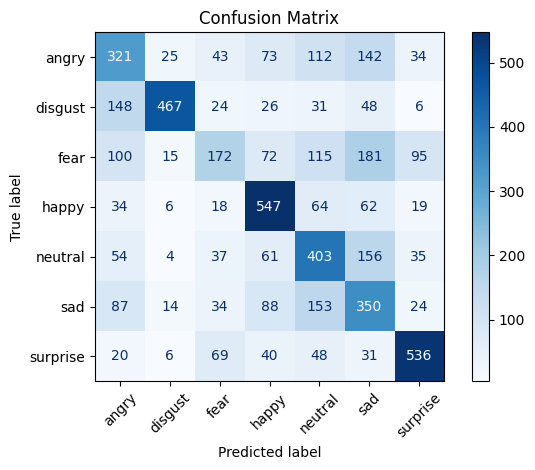

              precision    recall  f1-score   support

       angry       0.42      0.43      0.42       750
     disgust       0.87      0.62      0.73       750
        fear       0.43      0.23      0.30       750
       happy       0.60      0.73      0.66       750
     neutral       0.44      0.54      0.48       750
         sad       0.36      0.47      0.41       750
    surprise       0.72      0.71      0.72       750

    accuracy                           0.53      5250
   macro avg       0.55      0.53      0.53      5250
weighted avg       0.55      0.53      0.53      5250



In [4]:
# Get class names from the dataset
class_names = test_dataset.class_names

# Prepare lists to store true labels and predictions
y_true = []
y_pred = []

# Loop through the validation dataset
for images, labels in test_dataset:
    # Convert one-hot encoded labels back to class indices
    true_labels = tf.argmax(labels, axis=1).numpy()
    
    # Make predictions
    predictions = model.predict(images)
    pred_labels = np.argmax(predictions, axis=1)
    
    # Extend the lists
    y_true.extend(true_labels)
    y_pred.extend(pred_labels)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Show confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))